<a href="https://colab.research.google.com/github/ABD-01/Coreset/blob/master/cifar100/Coreset_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are 2 parts in this Notebook.

1.   [Finding the best samples](#Section1)
2.   [Training on those samples](#Section2)
3.   [Training on random samples](#Section3)



<a name="Section1"></a>
# Finding most valuable $n(=500)$ data samples from $50,000$ samples.

## Imports

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from functools import partial
from collections.abc import Iterable
from collections import OrderedDict
from operator import itemgetter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.utils import make_grid
from torchsummary import summary

%pip install functorch
from functorch import make_functional_with_buffers, vmap, grad
# from functorch.experimental import replace_all_batch_norm_modules_

# import jax
# import jax.numpy as jnp
# from jax import grad, jit, vmap
# from jax import random
# from jax.scipy.special import logsumexp
# from jax.example_libraries import stax, optimizers
# from jax.example_libraries.stax import BatchNorm, Conv, Dense, Flatten, Relu, AvgPool, LogSoftmax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(Device)

cuda:0


## Dataset

In [ ]:
def dataset_with_indices(cls):
    """
    Modifies the given Dataset class to return a tuple data, target, index
    instead of just data, target.
    """

    def __getitem__(self, index):
        data, target = cls.__getitem__(self, index)
        return data, target, index

    return type(cls.__name__, (cls,), {
        '__getitem__': __getitem__,
    })
# https://discuss.pytorch.org/t/how-to-retrieve-the-sample-indices-of-a-mini-batch/7948/19

In [ ]:
transform = Compose([ToTensor(), Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])
# train_data = CIFAR100("./", transform=transform, download=True)
CIFAR100WithIndices = dataset_with_indices(CIFAR100)
train_data = CIFAR100WithIndices("./", transform=transform, download=True)
train_data

Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )

In [ ]:
# def one_hot(x, k, dtype=jnp.float32):
#   """Create a one-hot encoding of x of size k."""
#   return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [ ]:
len(train_data.classes)

100

In [ ]:
num_classes = len(train_data.classes)
# train_images = jnp.array(train_images).reshape(50000, 32, 32, 3) # NWHC
# train_labels = one_hot(jnp.array(train_labels), num_classes)
# print("Train Images Shape", train_images.shape)
# print("Train Labels Shape", train_labels.shape)

In [ ]:
# def iterate_minibatches(inputs, targets, batchsize):
#     assert inputs.shape[0] == targets.shape[0]
#     assert train_images.shape[0] % batchsize == 0
#     for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
#         excerpt = slice(start_idx, start_idx + batchsize)
#         yield inputs[excerpt], targets[excerpt]

## Model

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim, dropout=True):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5) if dropout else nn.Identity(),
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        h = self.features(x)
        # h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x#, h

In [ ]:
model = AlexNet(100, False).to(Device)

In [ ]:
train_data[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
         MaxPool2d-2             [-1, 64, 8, 8]               0
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
         MaxPool2d-5            [-1, 192, 4, 4]               0
              ReLU-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
        MaxPool2d-12            [-1, 256, 2, 2]               0
             ReLU-13            [-1, 256, 2, 2]               0
          Flatten-14                 [-

In [ ]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.normal_(m.bias)
model.apply(init_weights)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Identity()
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU(inplace=True)
   

In [ ]:
BatchSize = 1000
assert len(train_data) % BatchSize == 0
loader = DataLoader(train_data, BatchSize, shuffle=True, num_workers=2, pin_memory=True)
# loader = iterate_minibatches(train_images, train_labels, batchsize=BatchSize)

## Too much memory Consumption

In [ ]:
# gradients = [[None, None] for i in range(len(params))]
# for i, batch in enumerate(loader):
#     images, labels = batch
#     gradient = batched_loss(params, images, labels)
#     if gradients[0][0] is not None:
#         for j in range(len(params)):
#             gradients[j][0] = np.concatenate([gradients[j][0], np.asarray(gradient[j][0])])
#             gradients[j][1] = np.concatenate([gradients[j][1], np.asarray(gradient[j][1])])
#     else:
#         for j in range(len(params)):
#             gradients[j][0] = np.asarray(gradient[j][0])
#             gradients[j][1] = np.asarray(gradient[j][1])
#     break

In [ ]:
# net_gradients = [[None, None] for i in range(len(params))]
# for j in range(len(params)):
#     net_gradients[j][0] = jnp.mean(gradients[j][0], axis=0)
#     net_gradients[j][1] = jnp.mean(gradients[j][1], axis=0)

In [ ]:
num_params = len(list(model.classifier.parameters()))
num_params

6

## Finding Net Gradient first

In [ ]:
def get_net_gradients(model, loader):
    net_gradients = [None for i in range(num_params)]
    num_iter = len(loader)
    progress_bar = tqdm(enumerate(loader), total = num_iter, desc="Net Gradients", leave=False)
    for i, batch in progress_bar:
        images, labels, _ = batch
        torch.cuda.empty_cache()
        images, labels = images.to(Device), labels.to(Device)
        output = model(images)
        gradient = torch.autograd.grad(F.nll_loss(output, labels), model.classifier.parameters())
        if net_gradients[0] is not None:
            for j in range(len(gradient)):
                net_gradients[j] += gradient[j].detach()#.cpu().numpy()
        else:
            for j in range(len(gradient)):
                net_gradients[j] = gradient[j].detach()#.cpu().numpy()

        for j in range(len(gradient)):
            net_gradients[j] /= num_iter

    return net_gradients
net_gradients = get_net_gradients(model, loader)

Net Gradients:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
net_gradients[0].device

device(type='cuda', index=0)

In [ ]:
net_gradients.__len__()

6

Finding Cosine Similarity between gradients per sample with gradient over entire dataset

In [ ]:
def cosinesimilarity(a,b):
    return np.divide(np.dot(a, b.T).squeeze(),  (np.linalg.norm(a, axis=-1) * np.linalg.norm(b)))
# def cosinesimilarity(a,b):
#     return jnp.divide(jnp.dot(a, b.T),  (jnp.linalg.norm(a) * jnp.linalg.norm(b)))

In [ ]:
def cs(a,b):
    a,b = a.view(1,-1), b.view(1,-1)
    return F.cosine_similarity(a,b)

In [ ]:
conv_net, params, buffers = make_functional_with_buffers(model.classifier)

In [ ]:
conv_net

FunctionalModuleWithBuffers(
  (stateless_model): Sequential(
    (0): Identity()
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Identity()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=100, bias=True)
    (7): LogSoftmax(dim=-1)
  )
)

In [ ]:
for x in params:
    print(f"Param: {x.shape}")

Param: torch.Size([512, 1024])
Param: torch.Size([512])
Param: torch.Size([256, 512])
Param: torch.Size([256])
Param: torch.Size([100, 256])
Param: torch.Size([100])


In [ ]:
@grad
def loss_gradient(params, x, y):
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    preds = conv_net(params, buffers, x)
    return F.nll_loss(preds, y)
batched_loss = vmap(loss_gradient, (None, 0,0), )

In [ ]:
F.cosine_similarity(torch.rand(500, 8), torch.rand(1, 8)).shape

torch.Size([500])

In [ ]:
import gc
gc.collect()

829

In [ ]:
def get_similarities(params, dataset, batch_size, net_gradients):
    loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    similarities = []
    img_indices = []
    progress_bar = tqdm(enumerate(loader), total = len(dataset)//batch_size, desc="Per Sample Gradient Similarity", leave=False)
    for i, batch in progress_bar:
        imgs, labels, inds = batch
        torch.cuda.empty_cache()
        imgs, labels, inds = imgs.to(Device), labels.to(Device), inds.numpy()
        with torch.no_grad():
            hidden_state = model.features(imgs)
        gradient = batched_loss(params, hidden_state, labels)
        gc.collect()
        torch.cuda.empty_cache()
        # gradient = torch.autograd.grad(F.nll_loss(model(imgs), labels), model.parameters())

        sim = torch.stack([F.cosine_similarity(a.view(batch_size, -1), b.view(1, -1)) for a,b in zip(gradient, net_gradients)], dim=-1).sum(dim=-1).detach().cpu().numpy()
        # sim = torch.stack(list(map(lambda, gradient, net_gradients))).sum()
        similarities.append(sim)
        img_indices.append(inds)
    return np.concatenate(similarities), np.concatenate(img_indices)
similarities, img_indices = get_similarities(params, train_data, 100, net_gradients)


Per Sample Gradient Similarity:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
similarities.shape, img_indices.shape

((50000,), (50000,))

## Finding top n similar samples for k iterations

In [ ]:
iterations = 100
# topn = 1000
BatchSize = 500
# good_inds = []
all_similarities, all_imginds = [], []
for k in tqdm(range(iterations), desc="Iterations"):
    torch.manual_seed(k)
    torch.cuda.manual_seed(k)
    loader = DataLoader(train_data, BatchSize, shuffle=True, num_workers=2, pin_memory=True)
    model = AlexNet(100, False).to(Device)
    model.apply(init_weights)
    conv_net, params, buffers = make_functional_with_buffers(model.classifier)
    net_gradients = get_net_gradients(model, loader)
    similarities, img_indices = get_similarities(params, train_data, BatchSize, net_gradients)

    all_similarities.append(similarities)
    all_imginds.append(img_indices)
    
    # inds = np.argpartition(-np.asarray(similarities).squeeze(), topn)[:topn]
    # good_inds.append(img_indices[inds])

# good_inds = np.concatenate(good_inds)

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/100 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/100 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/100 [00:00<?, ?it/s]

Per Sample Gradient Similarity:   0%|          | 0/100 [00:00<?, ?it/s]

Net Gradients:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
def get_sims_iter(iterations = 100):
    global all_similarities2, all_imginds2
    # topn = 1000
    BatchSize = 500
    # good_inds = []
    all_similarities2, all_imginds2 = [], []
    for k in tqdm(range(iterations), desc="Iterations"):
        print("Iter:", k)
        torch.manual_seed(k)
        torch.cuda.manual_seed(k)
        loader = DataLoader(train_data, BatchSize, shuffle=True, num_workers=2, pin_memory=True)
        model = AlexNet(100, False).to(Device)
        model.apply(init_weights)
        conv_net, params, buffers = make_functional_with_buffers(model.classifier)
        net_gradients = get_net_gradients(model, loader)
        similarities, img_indices = get_similarities(params, train_data, BatchSize, net_gradients)

        all_similarities2.append(similarities)
        all_imginds2.append(img_indices)
    
    print("Thread Completed")
        # inds = np.argpartition(-np.asarray(similarities).squeeze(), topn)[:topn]
        # good_inds.append(img_indices[inds])

    # good_inds = np.concatenate(good_inds)

In [ ]:
import threading
x = threading.Thread(target=get_sims_iter, args=(10,))
x.start()

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iter: 0


In [ ]:
np.stack(all_similarities2).shape, np.stack(all_imginds2).shape

((10, 50000), (10, 50000))

In [ ]:
all_similarities, all_imginds = np.stack(all_similarities), np.stack(all_imginds)

In [ ]:
np.save("all_similarities.npy", all_similarities)
np.save("all_imginds.npy", all_imginds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp -v all_similarities.npy /content/drive/MyDrive/Coreset_Experimentations/cifar_100
# !cp -v all_imginds.npy /content/drive/MyDrive/Coreset_Experimentations/cifar_100

'all_similarities.npy' -> '/content/drive/MyDrive/Coreset_Experimentations/cifar_100/all_similarities.npy'
'all_imginds.npy' -> '/content/drive/MyDrive/Coreset_Experimentations/cifar_100/all_imginds.npy'


In [ ]:
!gdown 1-ABOZh4HADuOhZDmHDZoFO2mlu7sREi3
!gdown 1-EDTwRu0_FwAoUczCqv5UGABwgqV68ZX

Downloading...
From: https://drive.google.com/uc?id=1-ABOZh4HADuOhZDmHDZoFO2mlu7sREi3
To: /content/all_imginds.npy
100% 40.0M/40.0M [00:00<00:00, 182MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-EDTwRu0_FwAoUczCqv5UGABwgqV68ZX
To: /content/all_similarities.npy
100% 20.0M/20.0M [00:00<00:00, 137MB/s]


In [ ]:
all_similarities = np.load("all_similarities.npy")
all_imginds = np.load("all_imginds.npy")

In [ ]:
all_similarities.shape, all_imginds.shape

((100, 50000), (100, 50000))

In [ ]:
# !cp -v all_* /content/drive/MyDrive/Coreset_Experimentations

In [ ]:
train_labels = torch.tensor(train_data.targets)

In [ ]:
train_labels.device

device(type='cpu')

### Class Balances Indices

In [ ]:
topn=500
good_inds = []
cls_good_inds = [[] for i in range(num_classes)]
topn_per_class = topn // num_classes
for k, (sims, inds) in tqdm(enumerate(zip(all_similarities, all_imginds))):
    # good_inds.append( inds[ np.argpartition(-sims, topn)[:topn] ] )
    shuffled_labels = train_labels[inds]
    for i in range(num_classes):
        cls_mask = np.where(shuffled_labels == i)[0]
        cls_sims = sims[cls_mask]
        cls_inds = inds[cls_mask]

        ind = np.argpartition(-cls_sims, topn_per_class)[:topn_per_class]
        good_ind = cls_inds[ind]
        # print(train_labels[good_ind])
        cls_good_inds[i].append(good_ind)

cls_good_inds = [np.concatenate(x) for x in cls_good_inds]

0it [00:00, ?it/s]

In [ ]:
best_inds = []
for cls_good_ind in cls_good_inds:
    values, counts = np.unique(cls_good_ind, return_counts=True)
    inds = np.argpartition(-counts, kth=topn_per_class)[:topn_per_class]
    best_inds.append(cls_good_ind[inds])
best_inds = np.concatenate(best_inds)
best_inds.shape

(500,)

In [ ]:
np.save(f"class_balanced_best_inds_{topn}.npy", best_inds)

### Class Unbalanced Indices

In [ ]:
topn = 500
good_inds = []
for k, (sims, inds) in tqdm(enumerate(zip(all_similarities, all_imginds))):
    
    ind = np.argpartition(-sims, topn)[:topn]
    good_inds.append(inds[ind])

good_inds = np.concatenate(good_inds)

0it [00:00, ?it/s]

In [ ]:
values, counts = np.unique(good_inds, return_counts=True)
# ref:https://stackoverflow.com/a/28736715/13730689
best_inds = np.argpartition(-counts, kth=topn)[:topn]
best_inds.shape

(500,)

In [ ]:
np.save(f"best_inds_{topn}.npy", best_inds)

In [ ]:
import requests #dependency

url = "https://discord.com/api/webhooks/988060502984904734/Qn2S1EBswB6DKR-VDEnIw1MkqjDXuphSJ4QixNWG0Y5bk-2R9dAut1aqkIpos2Bodx2k" #webhook url, from here: https://i.imgur.com/f9XnAew.png

#for all params, see https://discordapp.com/developers/docs/resources/webhook#execute-webhook
data = {"content" : f"best_inds_{topn}", "username" : "Colab"}
files = {
    'file': (f"best_inds_{topn}.pt", open(f"best_inds_{topn}.pt", 'rb')),
    
}
result = requests.post(url, json = data, files=files)

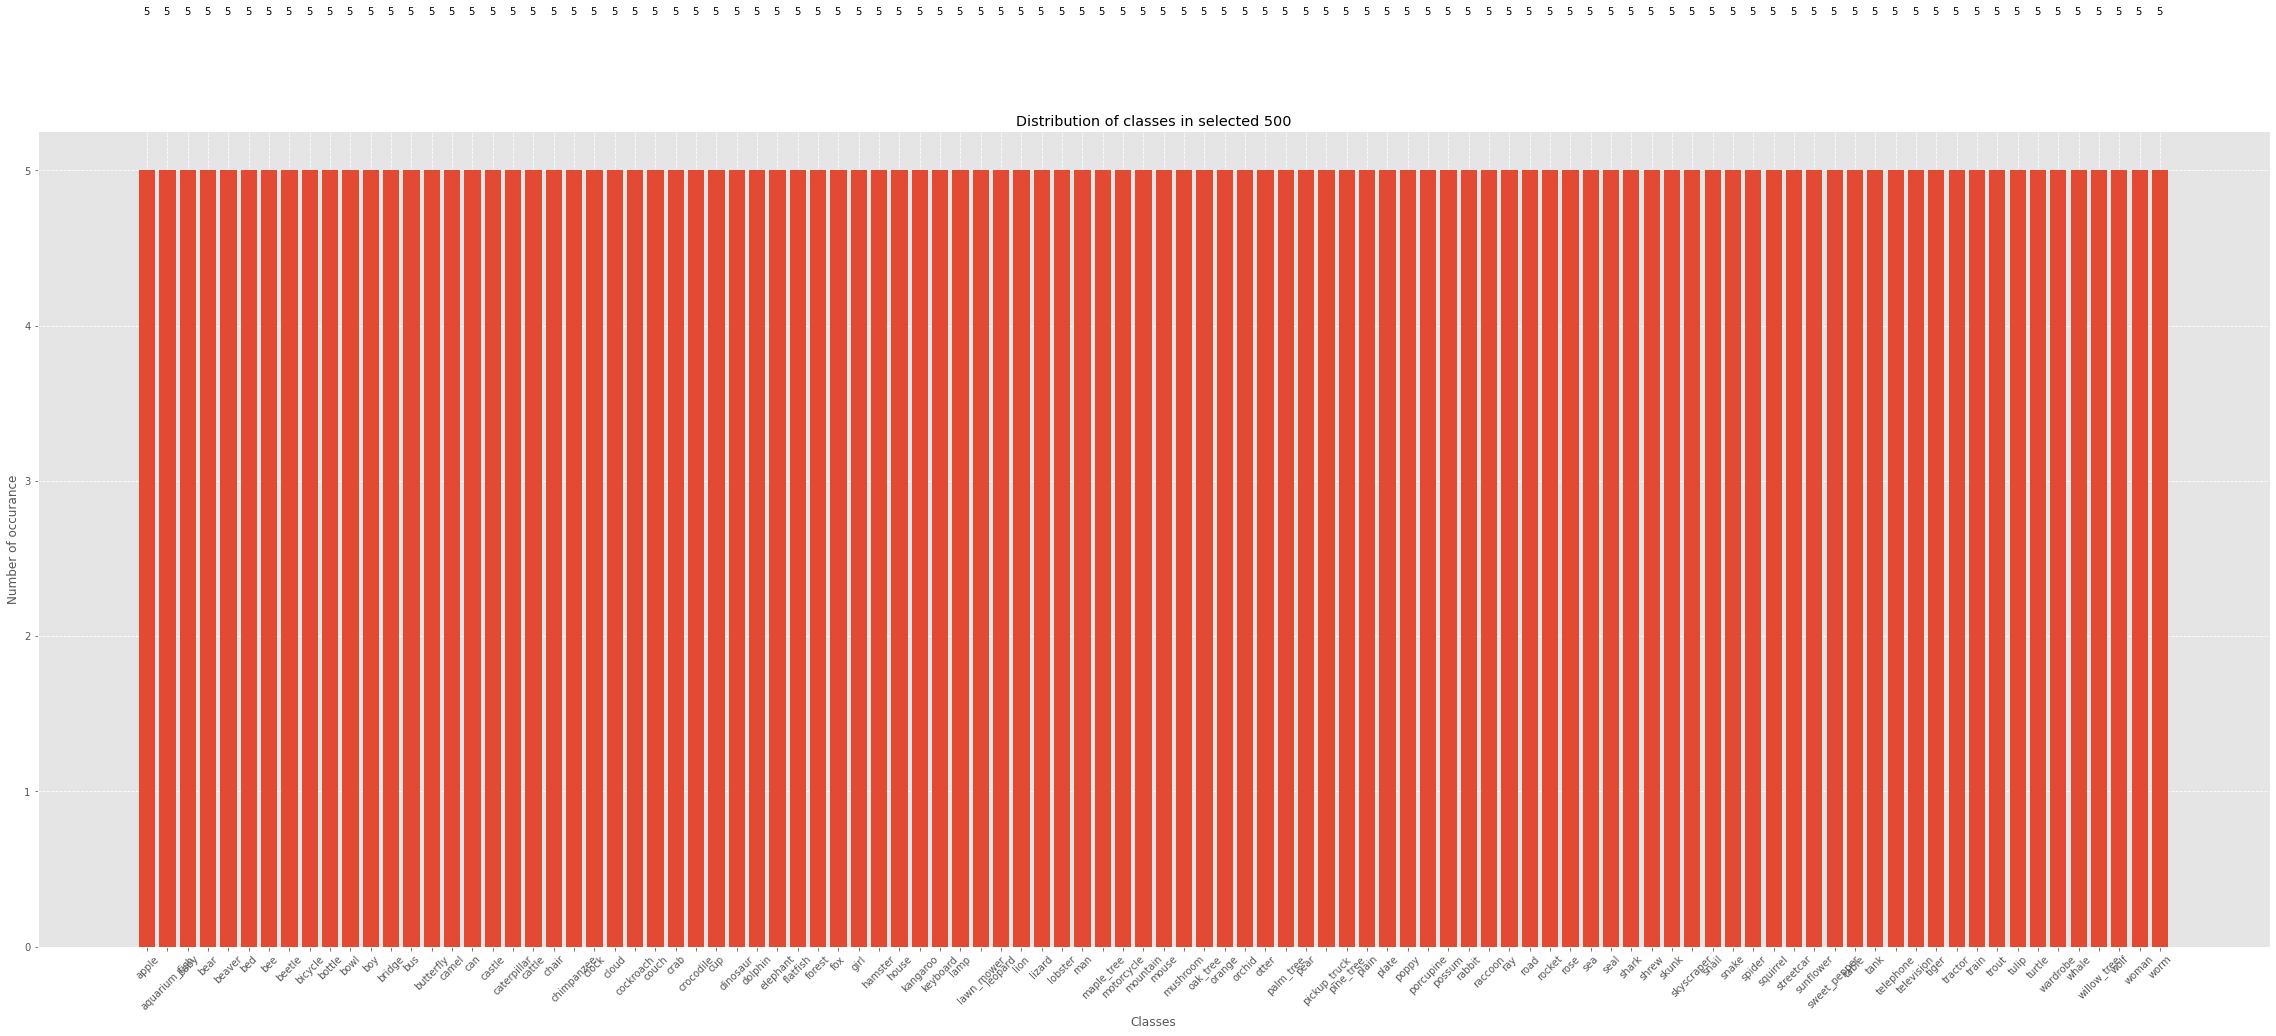

In [ ]:
plt.figure(figsize=(40, 15))
unique_and_counts = np.unique(train_labels[best_inds], return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0], train_data.classes, rotation=45)
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title(f"Distribution of classes in selected {topn}")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.savefig(f"freq_{topn}.png")
plt.show()

In [ ]:
data = {"content" : f"best_inds_{topn}","username" : "Colab"}
files = {
    'file': ("freq.png", open("freq.png", 'rb')),
}
result = requests.post(url, json = data, files=files)

In [ ]:
data = {
    "content" : "DONE",
    "username" : "Colab"
}
result = requests.post(url, json = data)

<a name="Section2"></a>
# Training on Sampled Data

In [ ]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(Device)

cuda:0


## Dataset

In [ ]:
best_inds = np.load(f"best_inds_{topn}.npy")
best_inds.shape

(500,)

In [ ]:
transform = Compose([ToTensor(), Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
data = Subset(CIFAR100("./", transform=transform, download=True), best_inds)
test_data = CIFAR100("./", False, transform=transform, download=True)
test_data

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )

In [ ]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([500, 3, 32, 32]), torch.Size([500]))

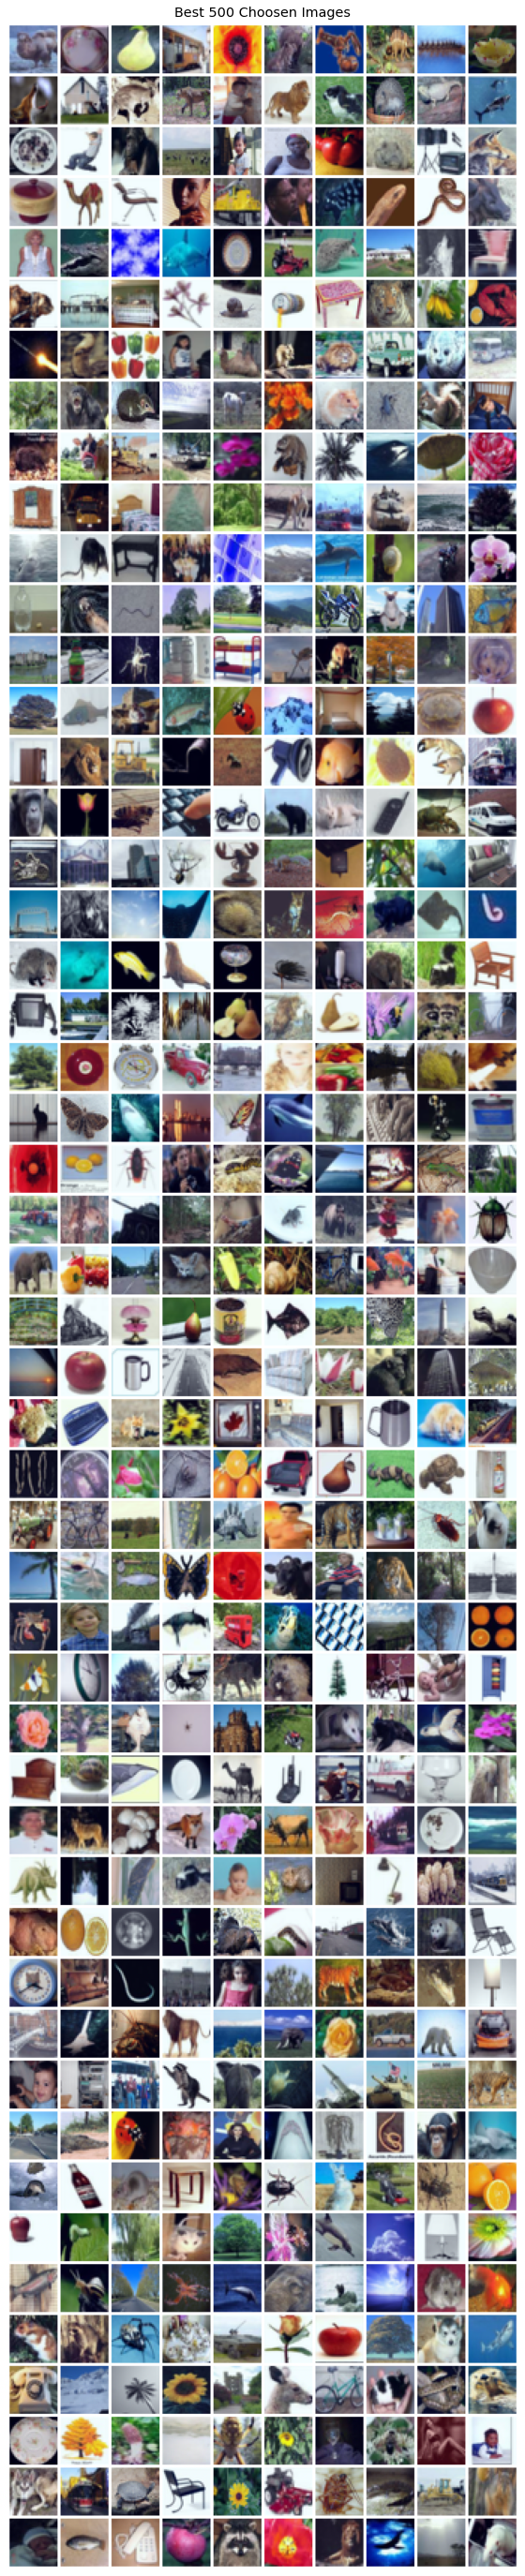

In [ ]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Best {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [ ]:
images = images.to(Device)
labels = labels.to(Device)
images.shape

torch.Size([500, 3, 32, 32])

In [ ]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = torch.split(images, sections)
train_labels, val_labels = torch.split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([450, 3, 32, 32]) torch.Size([450])
Val Set:  torch.Size([50, 3, 32, 32]) torch.Size([50])


In [ ]:
test_loader = DataLoader(test_data, batch_size=500, pin_memory=True)

## Model

In [ ]:
k = 53
torch.manual_seed(k)
torch.cuda.manual_seed(k)

In [ ]:
model = AlexNet(100).to(Device)

In [ ]:
model.apply(init_weights)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReL

## Training Utils

In [ ]:
from torch import no_grad

In [ ]:
@torch.inference_mode()
def test(loader, model):
    model.eval()
    correct = 0
    for (images, labels) in loader:
        images, labels = images.to(Device), labels.to(Device)
        output = model(images)
        acc = output.argmax(dim=1).eq(labels).sum().item()
        correct += acc
    return correct

In [ ]:
@torch.no_grad()
def val(val_i, val_l, model, criterion):
    model.eval()
    output = model(val_i)
    loss = criterion(output, val_l)
    acc = output.argmax(dim=1).eq(val_l).float().mean().item()
    return loss, acc

In [ ]:
lr = 0.001
optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.01, momentum=0.9)
criterion = nn.NLLLoss()

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=10, min_delta=1e-4):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        # if  val_acc < 0.3:
        #     return
        if self.best_acc == None:
            self.best_acc = val_acc
        elif val_acc - self.best_acc > self.min_delta:
            self.best_acc = val_acc
            # reset counter if validation acc improves
            self.counter = 0
        elif val_acc - self.best_acc < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
# ref : https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/

## Training Loop

In [ ]:
Epochs = 1000

In [ ]:
early_stopping = EarlyStopping(patience=20)
losses, accs, val_losses, val_accs = [], [], [], []
for epoch in tqdm(range(Epochs)):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    output = model(train_images)
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    accs.append(acc)
    val_loss, val_acc = val(val_images, val_labels, model, criterion)
    val_losses.append(val_loss.item())
    val_accs.append(val_acc)
    early_stopping(-val_loss)
    # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
    if epoch % 50 == 0:
        
        correct = test(test_loader, model)
        print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
        print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
    if early_stopping.early_stop:
        print(f"Trained for {epoch+1} Epochs.")
        break

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 6.59	Accuracy: 1.778	Val_Loss: 5.467	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 1.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 8 of 20
Epoch[  51] Loss: 4.88	Accuracy: 1.556	Val_Loss: 4.824	Val_Acc: 2.000
Epoch[  51] Test Accuracy: 1.000
INFO: Early stopping counter 9 of 20
INFO: Early stopping counter 10 of 20
INFO: Early stopping counter 11 of 20
INFO: Early stopping counter 12 of 20
INFO: Early stopping counter 13 of 20
INFO: Early stopping counter 14 of 20
INFO: Early stopping counter 15 of 20
INFO: Early stopping counter 16 of 20
INFO: Early stopping counter 17 of 20
INFO: Early stopping counter 18 of 20
INFO: Early stopping counter 19 of 20
INFO: Early stopping counter 20 of 20
INFO: Early stopping
Trained for 63 Epochs.

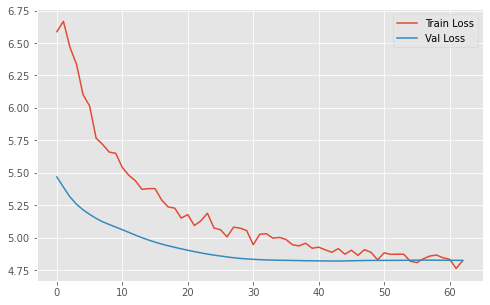

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.savefig(f"LossCurve_greedy{topn}")
plt.show()

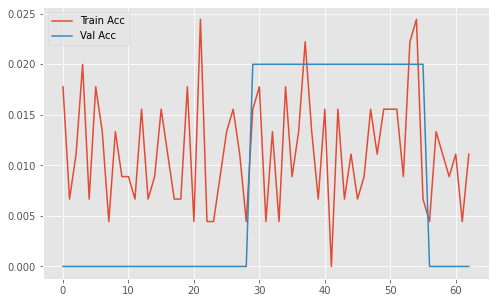

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig(f"AccCurve_greedy{topn}")
plt.show()

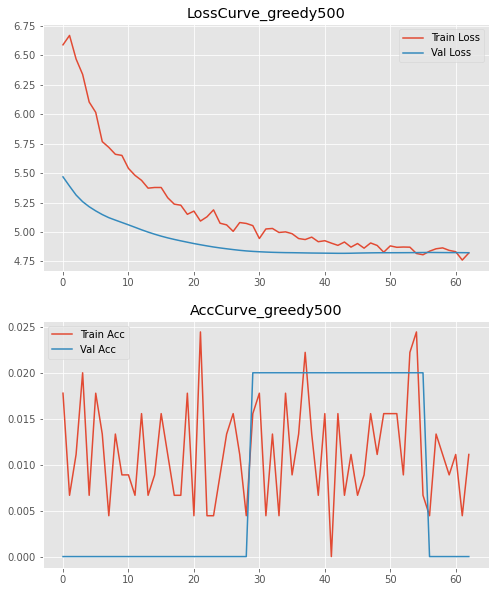

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,5*2))
# fig.suptitle('Learning Curves')
ax1.plot(losses, label="Train Loss")
ax1.plot(val_losses, label="Val Loss")
ax1.legend()
ax1.set_title(f"LossCurve_greedy{topn}")
ax2.plot(accs, label="Train Acc")
ax2.plot(val_accs, label="Val Acc")
ax2.legend()
ax2.set_title(f"AccCurve_greedy{topn}")
plt.savefig(f"LearningCurve_greedy{topn}")
plt.show()

In [ ]:
data = {
    "content" : f"GrredyCurves",
    "username" : "Colab"
}
files = {
    'file1': (f"LossCurve_greedy{topn}", open(f"LossCurve_greedy{topn}.png", 'rb')),
    'file2': (f"AccCurve_greedy{topn}", open(f"AccCurve_greedy{topn}.png", 'rb'))
    
}
result = requests.post(url, json = data, files=files)

In [ ]:
model.eval()
output = model(train_images)
acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
print("Accuracy on Train Set", acc*100)
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
test_acc = correct / len(test_data) * 100
print('Accuracy on Test Set:', test_acc)

Accuracy on Train Set 1.1111111380159855
100 correctly labeled out of 10000
Accuracy on Test Set: 1.0


In [ ]:
torch.save(model.state_dict(), f"Greedy_Model_{topn}n_Epochs_{Epochs}_Early_Stop_{epoch+1}_Test_Acc_{int(test_acc)}.pth")

In [ ]:
data = {
    "content" : f"GrredyCurves",
    "username" : "Colab"
}
files = {
    'file': (f"Greedy_Model_{topn}n_Epochs_{Epochs}_Early_Stop_{epoch+1}_Test_Acc_{int(test_acc)}", open(f"Greedy_Model_{topn}n_Epochs_{Epochs}_Early_Stop_{epoch+1}_Test_Acc_{int(test_acc)}.pth", 'rb')),    
}
result = requests.post(url, json = data, files=files)

In [ ]:
# model.load_state_dict(torch.load("/content/Greedy_Model_100n_Epochs_500_Early_Stop_73_Test_Acc_14.pth"))

<All keys matched successfully>

In [ ]:
# For Per Class Accuracy
model.eval()
all_preds, all_labels = [], []
for (images, labels) in test_loader:
    images, labels = images.to(Device), labels.to(Device)
    output = model(images)
    preds = output.argmax(dim=1)
    all_preds.append(preds.cpu().detach().numpy())
    all_labels.append(labels.cpu().numpy())
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

In [ ]:
correct = np.equal(all_preds, all_labels).sum()
correct

100

In [ ]:
from sklearn.metrics import confusion_matrix
from prettytable import PrettyTable  
acctable = PrettyTable(["Class", "Accuracy"])  
matrix = confusion_matrix(all_labels, all_preds)
per_cls_acc = matrix.diagonal()/matrix.sum(axis=1)
for a, c in zip(per_cls_acc, train_data.classes):
    acctable.add_row([c, f"{a*100:.2f}"])
    # print(f"Class: {c}\tAccuracy: {a*100:.2f}")
print(acctable)

+---------------+----------+
|     Class     | Accuracy |
+---------------+----------+
|     apple     |   0.00   |
| aquarium_fish |   0.00   |
|      baby     |   0.00   |
|      bear     |   0.00   |
|     beaver    |   0.00   |
|      bed      |   0.00   |
|      bee      |   0.00   |
|     beetle    |   0.00   |
|    bicycle    |   0.00   |
|     bottle    |   0.00   |
|      bowl     |   0.00   |
|      boy      |   0.00   |
|     bridge    |   0.00   |
|      bus      |   0.00   |
|   butterfly   |   0.00   |
|     camel     |   0.00   |
|      can      |   0.00   |
|     castle    |   0.00   |
|  caterpillar  |   0.00   |
|     cattle    |   0.00   |
|     chair     |   0.00   |
|   chimpanzee  |   0.00   |
|     clock     |   0.00   |
|     cloud     |   0.00   |
|   cockroach   |   0.00   |
|     couch     |   0.00   |
|      crab     |   0.00   |
|   crocodile   |   0.00   |
|      cup      |   0.00   |
|    dinosaur   |   0.00   |
|    dolphin    |   0.00   |
|    elephant 

In [ ]:
print(acctable.get_html_string())


<a name="Section3"></a>
# Training on Randomly Sampled Data

In [ ]:
Rand_Train_Acc, Rand_Val_Acc = [], []

## Dataset

In [ ]:
transform = Compose([ToTensor(), Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
train_data = CIFAR100("./", transform=transform, download=True)
test_data = CIFAR100("./", False, transform=transform, download=True)
test_data

Files already downloaded and verified
Files already downloaded and verified


Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))
           )

In [ ]:
train_labels = torch.tensor(train_data.targets)
train_inds = torch.arange(len(train_data))

In [ ]:
def get_cls_balanced_inds(elem_per_class):
    inds = []
    for i in range(num_classes):
        ind = np.random.choice(train_inds[torch.tensor(train_data.targets)==i], elem_per_class)
        inds.append(ind)
    inds = np.concatenate(inds)
    np.random.shuffle(inds)
    return inds

In [ ]:
topn_per_class = topn//num_classes
topn_per_class

5

In [ ]:
# inds = torch.randint(0, 50000, (topn,))
inds = get_cls_balanced_inds(topn_per_class)
inds.shape

(500,)

In [ ]:
data = Subset(train_data, inds)

In [ ]:
def get_dataset(cls_balanced = False):
    if cls_balanced:
        inds = get_cls_balanced_inds(topn_per_class)
    else:
        inds = torch.randint(0, 50000, (topn,))
    transform = Compose([ToTensor(), Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])
    data = Subset(CIFAR10("./", transform=transform, download=True), inds)
    test_data = CIFAR10("./", False, transform=transform, download=True)
    return data, test_data

In [ ]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([500, 3, 32, 32]), torch.Size([500]))

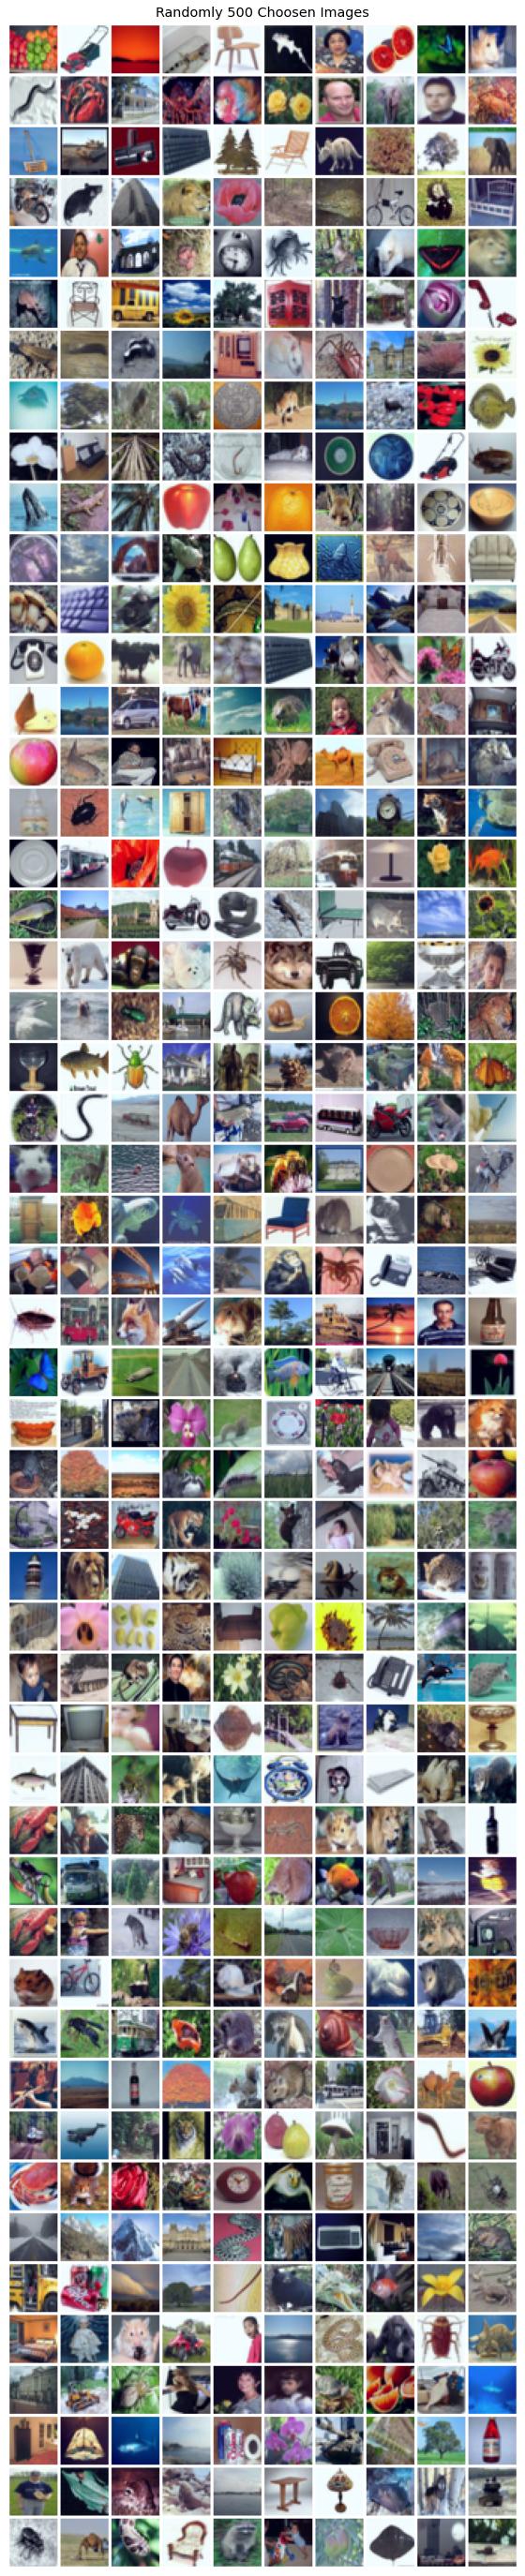

In [ ]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)
plt.figure(figsize=(10, topn//10))
plt.title(f"Randomly {topn} Choosen Images")
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')
plt.show()

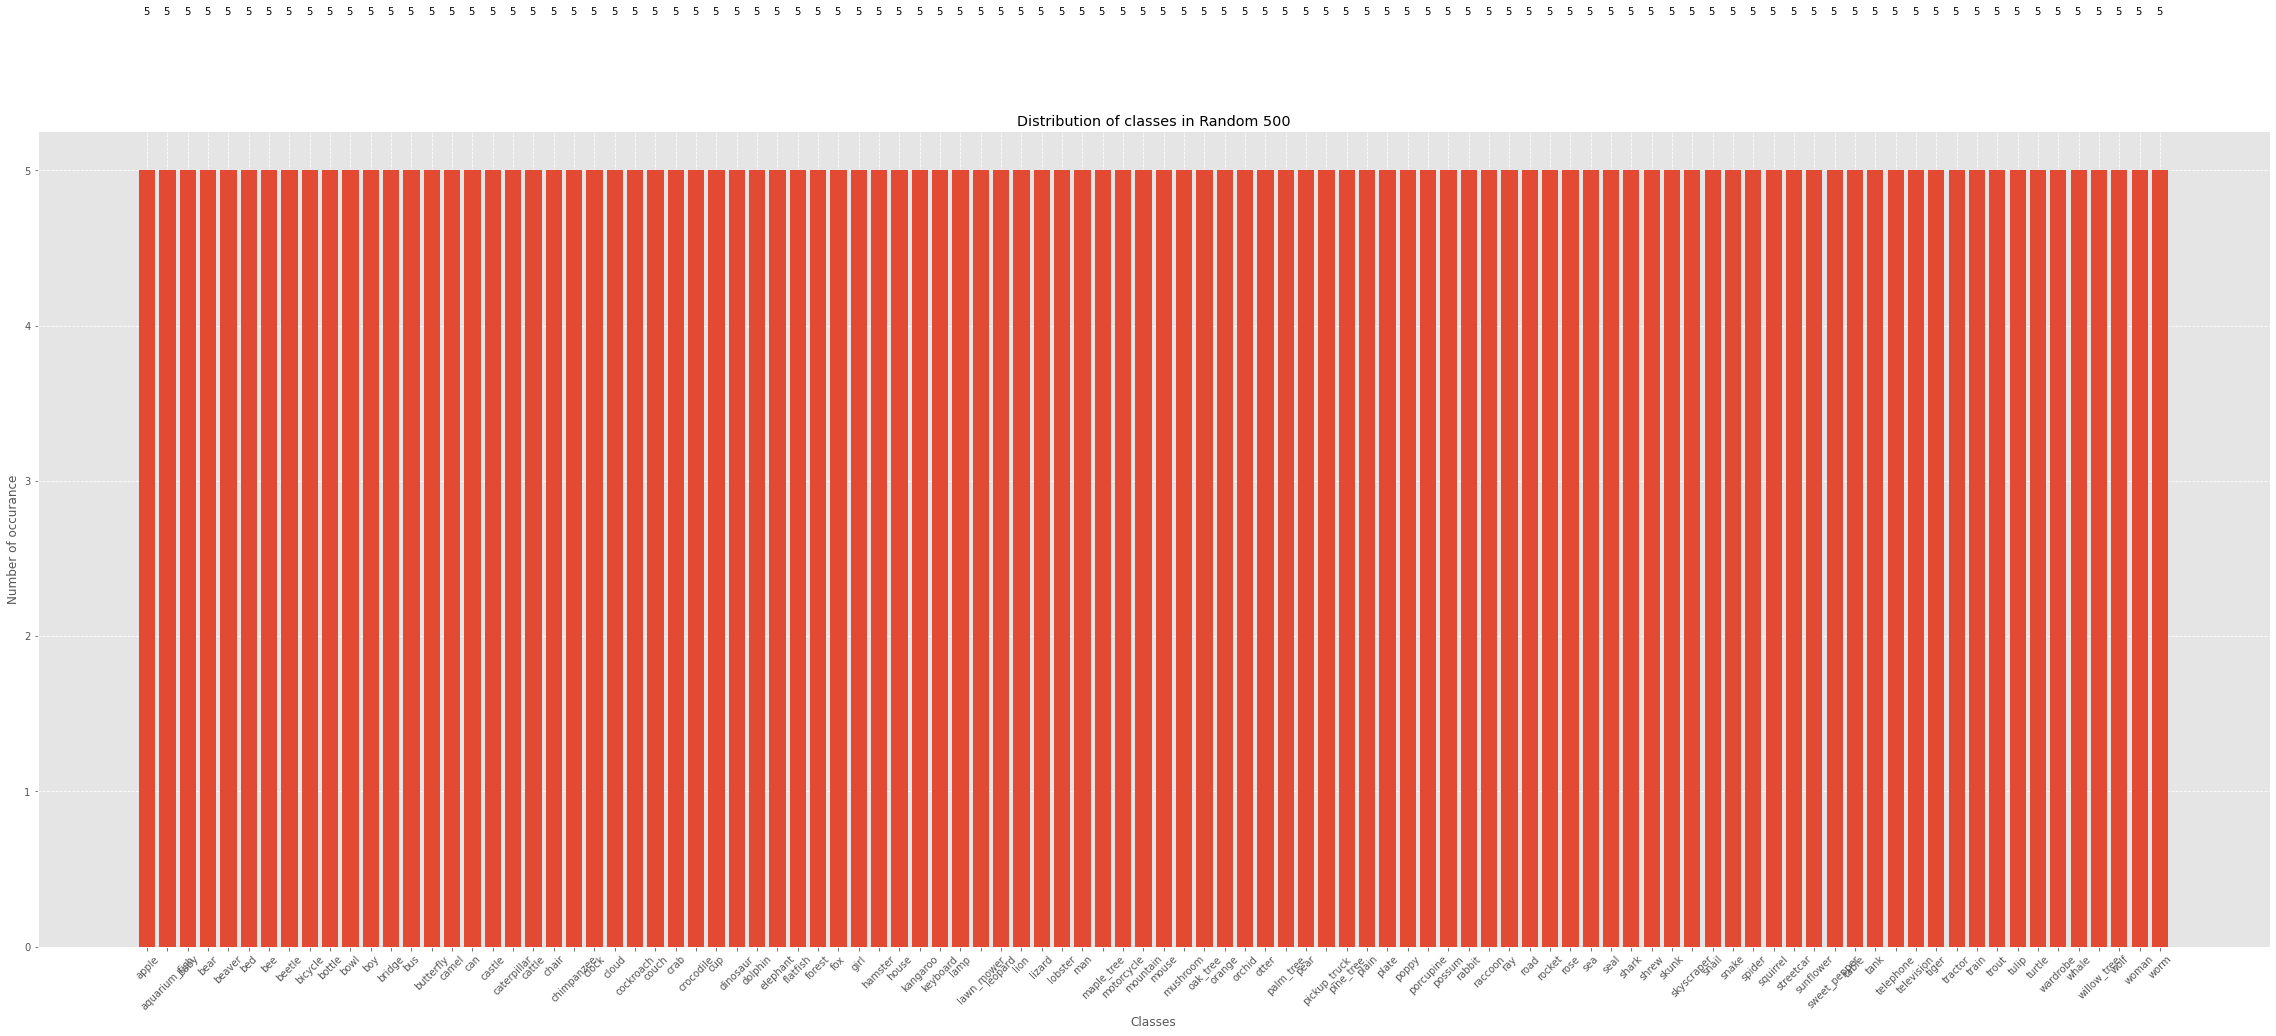

In [ ]:
plt.figure(figsize=(40, 15))
unique_and_counts = np.unique(labels, return_counts=True)
plt.bar(*unique_and_counts)
plt.xticks(unique_and_counts[0], train_data.classes, rotation=45)
plt.xlabel("Classes")
plt.ylabel('Number of occurance')
plt.title(f"Distribution of classes in Random {topn}")
plt.grid(linestyle='--')
for i, v in enumerate(unique_and_counts[1]):
    plt.text(i-0.2, v + 1, str(v))
plt.show()

In [ ]:
images = images.to(Device)
labels = labels.to(Device)
images.shape

torch.Size([500, 3, 32, 32])

In [ ]:
val_size = int(0.1*labels.shape[0])
sections = (labels.shape[0]-val_size, val_size)
train_images, val_images = torch.split(images, sections)
train_labels, val_labels = torch.split(labels, sections)
print("Train Set: ", train_images.shape, train_labels.shape)
print("Val Set: ", val_images.shape, val_labels.shape)

Train Set:  torch.Size([450, 3, 32, 32]) torch.Size([450])
Val Set:  torch.Size([50, 3, 32, 32]) torch.Size([50])


In [ ]:
test_loader = DataLoader(test_data, batch_size=500, num_workers=2, pin_memory=True)

## Training Loop

In [ ]:
cls_balanced = False
Epochs = 1000

  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.64	Accuracy: 0.222	Val_Loss: 4.633	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 0.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
Epoch[  51] Loss: 2.48	Accuracy: 10.444	Val_Loss: 2.378	Val_Acc: 8.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early sto

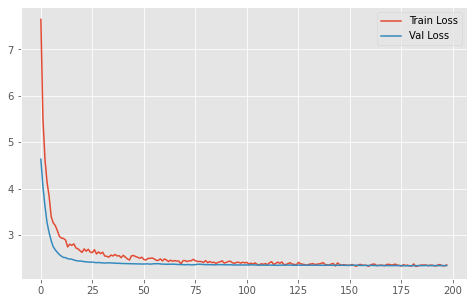

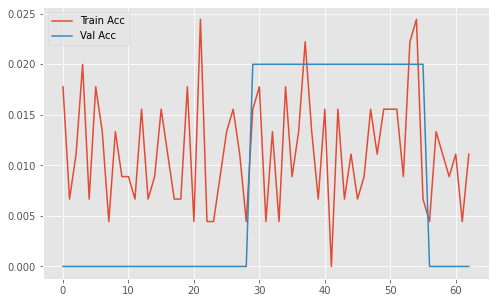

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.13	Accuracy: 0.444	Val_Loss: 4.192	Val_Acc: 8.000
Epoch[   1] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 8 of 20
Epoch[  51] Loss: 2.49	Accuracy: 11.111	Val_L

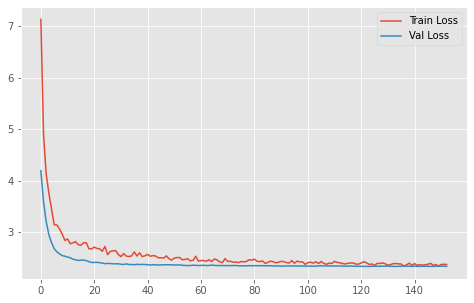

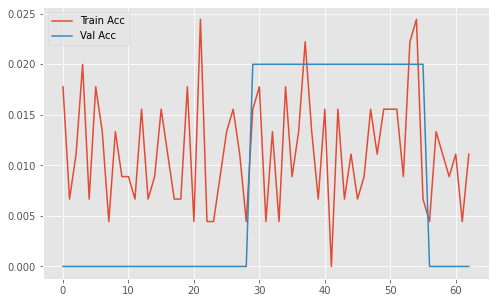

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.28	Accuracy: 0.889	Val_Loss: 3.973	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 0.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 1 of 20
Epoch[  51] Loss: 2.48	Accuracy: 10.667	Val_Loss: 2.362	Val_Acc: 16.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early st

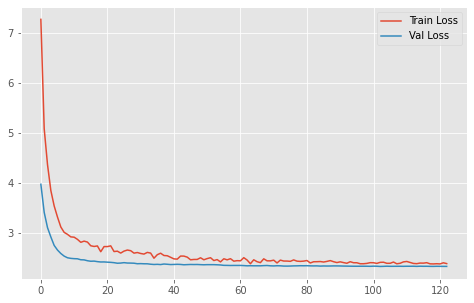

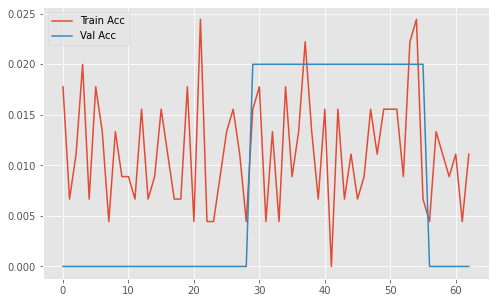

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 6.51	Accuracy: 0.444	Val_Loss: 3.812	Val_Acc: 14.000
Epoch[   1] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 8 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
Epoch[  51] Loss: 2.50	Accuracy: 9.778	Val_L

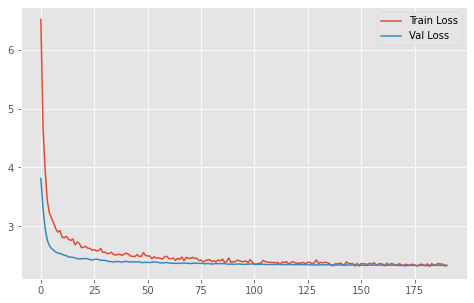

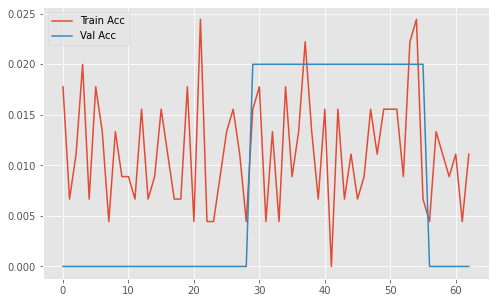

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.31	Accuracy: 0.222	Val_Loss: 4.161	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 0.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
Epoch[  51] Loss: 2.49	Accuracy: 11.778	Val_Loss: 2.329	Val_Acc: 12.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early st

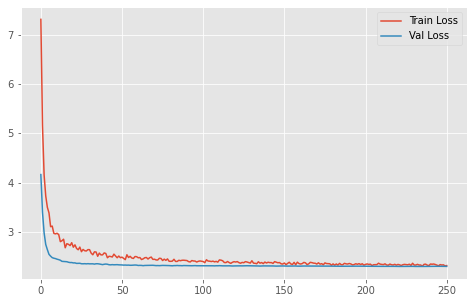

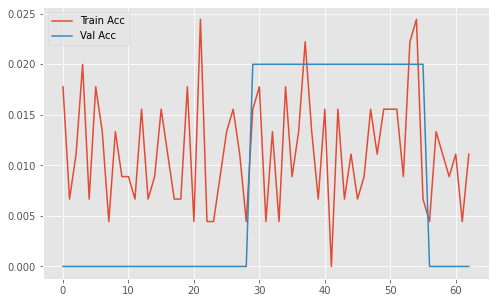

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.82	Accuracy: 0.000	Val_Loss: 4.831	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 0.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 8 of 20
INFO: Early stopping counter 9 of 20
INFO: Early stopping counter 10 of 20
INFO: Ea

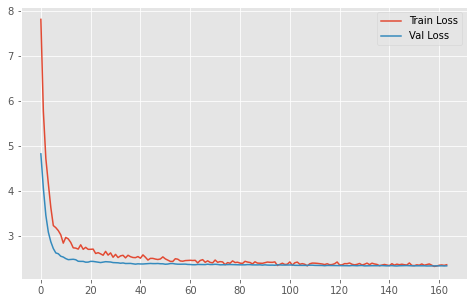

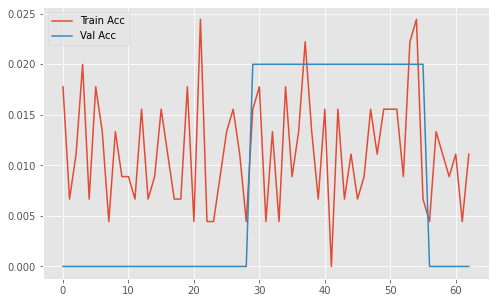

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 6.97	Accuracy: 1.556	Val_Loss: 4.272	Val_Acc: 8.000
Epoch[   1] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
Epoch[  51] Loss: 2.51	Accuracy: 9.778	Val_Loss: 2.308	Val_Acc: 18.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early st

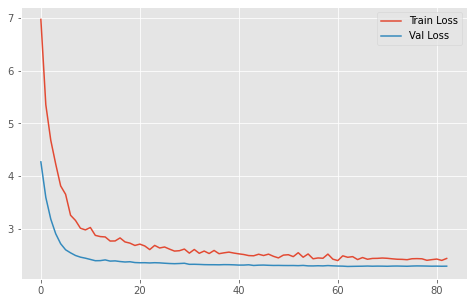

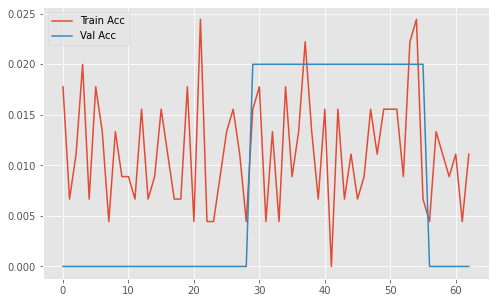

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.94	Accuracy: 3.556	Val_Loss: 3.832	Val_Acc: 6.000
Epoch[   1] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 7 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Ea

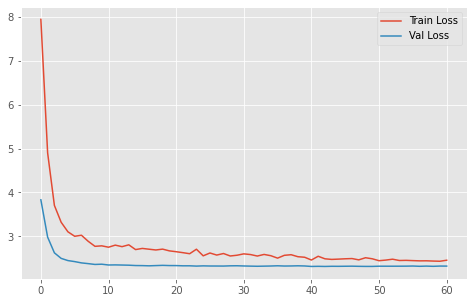

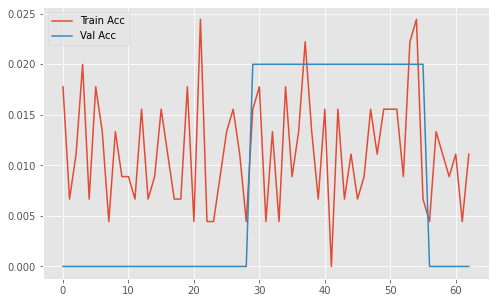

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 7.06	Accuracy: 0.667	Val_Loss: 4.454	Val_Acc: 0.000
Epoch[   1] Test Accuracy: 0.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
Epoch[  51] Loss: 2.48	Accuracy: 10.667	Val_Loss: 2.411	Val_Acc: 8.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early sto

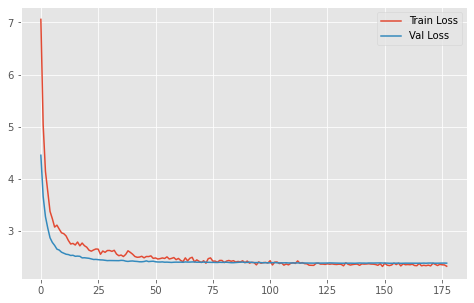

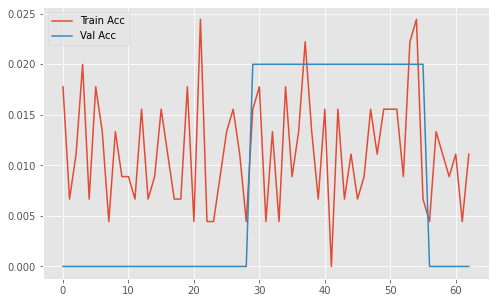

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch[   1] Loss: 6.75	Accuracy: 0.444	Val_Loss: 4.254	Val_Acc: 6.000
Epoch[   1] Test Accuracy: 10.000
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 4 of 20
INFO: Early stopping counter 5 of 20
INFO: Early stopping counter 6 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
INFO: Early stopping counter 3 of 20
INFO: Early stopping counter 1 of 20
INFO: Early stopping counter 2 of 20
Epoch[  51] Loss: 2.54	Accuracy: 10.889	Val_Loss: 2.395	Val_Acc: 6.000
Epoch[  51] Test Accuracy: 10.000
INFO: Early st

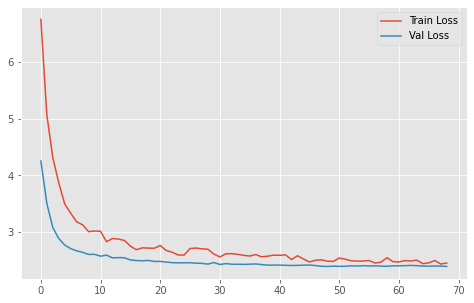

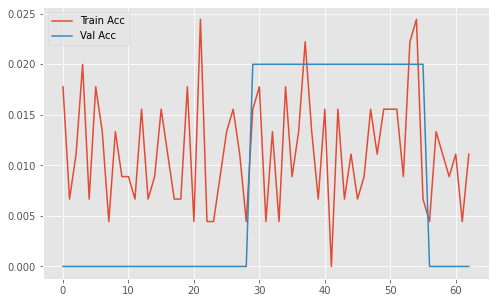

In [ ]:
for i in tqdm(range(10)):

    ### Dataset
    data, test_data = get_dataset(cls_balanced)
    images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
    images = images.to(Device)
    labels = labels.to(Device)

    val_size = int(0.1*labels.shape[0])
    sections = (labels.shape[0]-val_size, val_size)
    train_images, val_images = torch.split(images, sections)
    train_labels, val_labels = torch.split(labels, sections)

    test_loader = DataLoader(test_data, batch_size=500, num_workers=2, pin_memory=True)

    ### Model
    model = AlexNet(100).to(Device)
    model.apply(init_weights)

    ### Train Utils
    lr = 0.01
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=0.09, momentum=0.1)
    criterion = nn.NLLLoss()

    ### Train Loop
    early_stopping = EarlyStopping(patience=20)
    losses2, accs2, val_losses2, val_accs2 = [], [], [], []
    for epoch in tqdm(range(Epochs)):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        output = model(train_images)
        loss = criterion(output, train_labels)
        loss.backward()
        optimizer.step()
        losses2.append(loss.item())
        acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
        accs2.append(acc)
        val_loss, val_acc = val(val_images, val_labels, model, criterion)
        val_losses2.append(val_loss.item())
        val_accs2.append(val_acc)
        early_stopping(-val_loss)
        # print(f"Epoch[{epoch+1:4}] Val_Loss: {val_loss:.3f}\tVal_Acc: {val_acc:.3f}")
        if epoch % 50 == 0:
            
            correct = test(test_loader, model)
            print(f"Epoch[{epoch+1:4}] Loss: {loss.item():.2f}\tAccuracy: {acc*100 :.3f}\tVal_Loss: {val_loss:.3f}\tVal_Acc: {val_acc*100:.3f}")
            print(f"Epoch[{epoch+1:4}] Test Accuracy: {(correct / len(test_data))*100 :.3f}")
        if early_stopping.early_stop:
            print(f"Trained for {epoch+1} Epochs.")
            break

    plt.figure(figsize=(8,5))
    plt.plot(losses2, label="Train Loss")
    plt.plot(val_losses2, label="Val Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.show()

    model.eval()
    output = model(train_images)
    acc = output.argmax(dim=1).eq(train_labels).float().mean().item()
    Rand_Train_Acc.append(acc*100)
    correct = test(test_loader, model)
    Rand_Val_Acc.append((correct / len(test_data))*100)

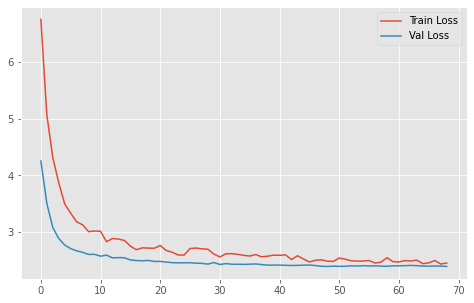

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(losses2, label="Train Loss")
plt.plot(val_losses2, label="Val Loss")
plt.legend()
plt.savefig("LossCurve_random100")
plt.show()

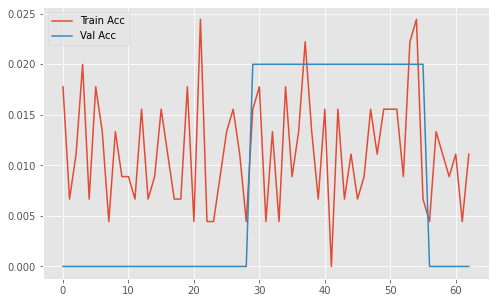

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.savefig("AccCurve_random100")
plt.show()

In [ ]:
model.eval()
correct = test(test_loader, model)
print(correct, 'correctly labeled out of', len(test_data))
print('Accuracy on Test Set:', correct / len(test_data) * 100)

1000 correctly labeled out of 10000
Accuracy on Test Set: 10.0


In [ ]:
print(f"Mean Train Accuracy on Random {topn} Train Samples is {np.mean(Rand_Train_Acc):.3f}±{np.std(Rand_Train_Acc):.2f}%")
print(f"Mean Test   Accuracy on Random {topn} Train Samples is {np.mean(Rand_Val_Acc):.3f}±{np.std(Rand_Val_Acc):.2f}%")

Mean Train Accuracy on Random 500 Train Samples is 12.311±0.60%
Mean Test   Accuracy on Random 500 Train Samples is 10.005±0.02%
